In [62]:
import numpy as np
from matplotlib import pyplot as plt

In [63]:
def mulp(A, x):
    y = [0, 0, 0, 0, 0]
    for i in range (5):
        for j in range (5):
            y[i] += A[i][j] * x[j]
    y = np.array(y)
    return y

def norm(x):
    sum = 0
    for i in range (5):
        sum += x[i]**2
    return np.sqrt(sum)

def diag(arr):
    if len(arr.shape) == 2:  # Проверяем, является ли входной массив двумерным
        # Извлечение диагонали из двумерного массива
        return np.array([arr[i][i] for i in range(min(len(arr), len(arr[0])))])
    else:
        # Создание двумерной диагональной матрицы из одномерного массива
        size = len(arr)
        from pprint import pprint
        pprint(arr)
        return np.array([[arr[i] if i == j else 0 for j in range(size)] for i in range(size)])


## Вариант 6. Воробьев Игорь

Решить систему уравнений с помощью LU-разложения и метода Якоби с точностью
$10^{-3}$, сравнить результаты. Построить график ошибки и критерия останова на каждой итерации метода Якоби. Проверить строгое диагональное преобладание, решить задачу со значительным нарушением диагонального преобладания (изменить коэффициенты матрицы), построить график ошибки.

In [64]:
A = np.array([
    [13.1, -4.91, 3.7, -3.58, 2.4],
    [0, -10.04, -2.43, 3.3, 4.43],
    [-2.06, 3.49, -11.32, 2.47, -2.32],
    [3.62, -1.78, 2.52, 8.79, 0.21],
    [2.64, 0, -3.86, 4.7, 12.8]
])

f = np.array([137.63, 104.76, -123.4, 135.61, 157.9])

#### Решаем с помощью LU-разложения

Воспользуемся алгоритмом для нахождения матриц L и U:
\begin{aligned}
& a_{11}=u_{11}, a_{12}=u_{12}, \ldots \\
& u_{i j}=a_{i j}-\sum_{k=1}^{i-1} l_{i k} u_{k j}, i \leq j ; \quad l_{i j}=u_{j j}^{-1}\left(a_{i j}-\sum_{k=1}^{j-1} l_{i k} u_{k j}\right), i>j
\end{aligned}

In [65]:
# LU декомпозиция
def lu_decomposition(A):
    N = len(A)
    L = np.zeros_like(A)
    U = np.zeros_like(A)
    
    for i in range(N):
        L[i][i] = 1
        for j in range(i, N):
            sum1 = np.float64(0)
            for k in range(i):
                sum1 += L[i][k] * U[k][j]
            U[i][j] = A[i][j] - sum1
        
        for j in range(i+1, N):
            sum2 = np.float64(0)
            for k in range(i):
                sum2 += L[j][k] * U[k][i]
            L[j][i] = (A[j][i] - sum2) / U[i][i]
            
    return L, U

# Прямая
def forward_substitution(L, b):
    N = len(b)
    y = np.zeros_like(b)
    
    for i in range(N):
        sum1 = np.float64(0)
        for j in range(i):
            sum1 += L[i][j] * y[j]
        y[i] = (b[i] - sum1) / L[i][i]
    
    return y

# Обратная
def backward_substitution(U, y):
    N = len(y)
    x = np.zeros_like(y)
    
    for i in range(N-1, -1, -1):
        sum1 = np.float64(0)
        for j in range(i+1, N):
            sum1 += U[i][j] * x[j]
        x[i] = (y[i] - sum1) / U[i][i]
    
    return x

In [66]:
L, U = lu_decomposition(A)
y = forward_substitution(L, f)
x_lu = backward_substitution(U, y)

x_lu

array([ 7., -5.,  8.,  9., 10.])

Сравним с эталоном

In [67]:
from scipy.linalg import lu_factor, lu_solve

lu, piv = lu_factor(A)
x_lu_py = lu_solve((lu, piv), f)

x_lu_py

array([ 7., -5.,  8.,  9., 10.])

#### Решение методом Якоби с точностью $10^{-3}$

In [68]:
# Якоби
def jacobi_method(A, b, tolerance=1e-3, max_iterations=100):
    x = np.zeros_like(b)
    D = diag(diag(A))
    R = A - D
    
    for _ in range(max_iterations):
        x_new = (b - mulp(R, x)) / diag(A)
        if norm(x_new - x) < tolerance:
            print(norm(x_new - x), tolerance)
            return x_new
        x = x_new
    
    return x

In [69]:
x_jacobi = jacobi_method(A, f)

x_jacobi

array([ 13.1 , -10.04, -11.32,   8.79,  12.8 ])
0.0005999554802707826 0.001


array([ 7.00012176, -5.0000871 ,  8.00010436,  9.00014184, 10.00004491])

#### Сравним решения

In [70]:
print(x_lu, x_jacobi, x_lu_py, sep="\n")

[ 7. -5.  8.  9. 10.]
[ 7.00012176 -5.0000871   8.00010436  9.00014184 10.00004491]
[ 7. -5.  8.  9. 10.]


#### Построить график ошибки и критерия останова на каждой итерации метода Якоби.

![Alt Text](якоби.png)


In [71]:
error = []
ostan = []

# С записью ошибок и критерия останова
def jacobi_method_logs(A, b, tolerance=1e-3, max_iterations=100):
    global error, ostan

    x = np.zeros_like(b)
    D = diag(diag(A))
    R = A - D
    
    for _ in range(max_iterations):
        x_new = (b - mulp(R, x)) / diag(A)
        error.append(norm(x_new - x_lu_py))
        ostan.append(norm(x_new - x))
        if np.linalg.norm(x_new - x) < tolerance:
            return x_new
        x = x_new
    
    return x

In [72]:
jacobi_method_logs(A, f)

array([ 13.1 , -10.04, -11.32,   8.79,  12.8 ])


array([ 7.00012176, -5.0000871 ,  8.00010436,  9.00014184, 10.00004491])

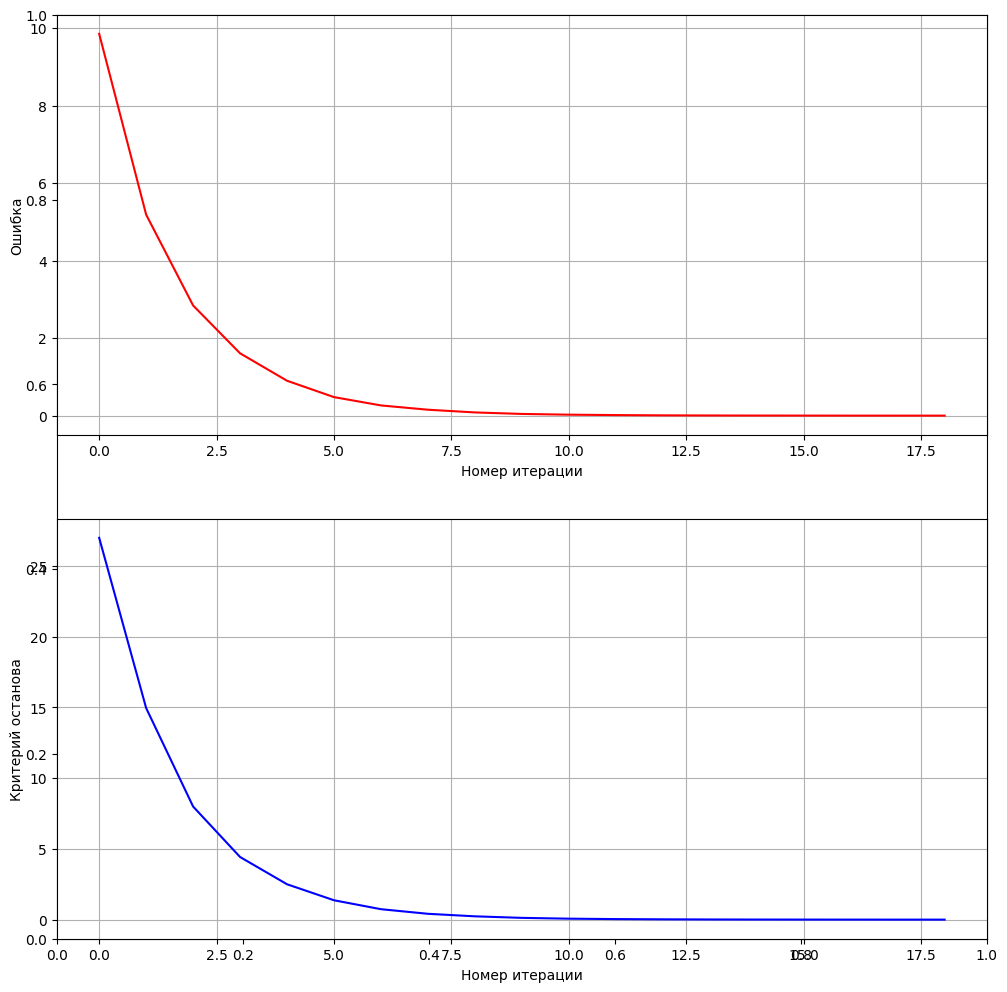

0.00023545795478834561 0.0005999554802707826


In [73]:
fig, ax = plt.subplots(figsize = (12,12))
plt.subplot(2, 1, 1)
plt.plot(error, c = 'red', label = 'Ошибка')
plt.grid()
plt.xlabel('Номер итерации')
plt.ylabel('Ошибка')

plt.subplot(2, 1, 2)
plt.plot(ostan, c = 'blue', label = 'Критерий останова')
plt.grid()
plt.xlabel('Номер итерации')
plt.ylabel('Критерий останова')
plt.show()
print(error[-1], ostan[-1])

#### Проверить строгое диагональное преобладание

Для матрицы $A$ с элементами $a_{ij}$, где $i$ обозначает номер строки, а $j$ — номер столбца, матрица $A$ считается строго диагонально доминирующей, если выполняется следующее условие для всех $i$:

$$|a_{ii}| > \sum_{\substack{j=1 \\ j \neq i}}^{n} |a_{ij}|, \quad \forall i = 1, 2, ..., n$$

где $n$ — размерность матрицы.


In [74]:
def is_strictly_diagonally_dominant(matrix):
    # Получаем размер матрицы
    n = matrix.shape[0]
    
    # Проверяем строгое диагональное преобладание
    for i in range(n):
        # Сумма модулей всех элементов строки, кроме диагонального
        row_sum = np.float64(0)
        for j in range(n):
            if i != j:
                row_sum += abs(matrix[i, j])
        # Модуль диагонального элемента
        diag_element = abs(matrix[i, i])
        # Проверяем условие
        if float(diag_element) <= float(row_sum):
            print(diag_element, row_sum)
            return False
    return True

# Проверка матрицы на строгое диагональное преобладание
is_strictly_diagonally_dominant(A)

13.1 14.59


False

#### Решить задачу со значительным нарушением диагонального преобладания (изменить коэффициенты матрицы), построить график ошибки

In [75]:
A_ = np.array([
    [13.1, -4.91, 3.7, -3.58, 2.4],
    [12, -10.04, -2.43, 3.3, 4.43],
    [-2.06, 3.49, -11.32, 2.47, -2.32],
    [3.62, -1.78, 2.52, 8.79, 0.21],
    [2.64, 12, -3.86, 4.7, 12.8]
])

In [76]:
is_strictly_diagonally_dominant(A_)

13.1 14.59


False

In [77]:
error = []
ostan = []

jacobi_method_logs(A_, f)

array([ 13.1 , -10.04, -11.32,   8.79,  12.8 ])


array([10.47123654,  4.8165548 , 11.19370875,  8.74218351,  5.82647296])

Text(0, 0.5, 'Ошибка')

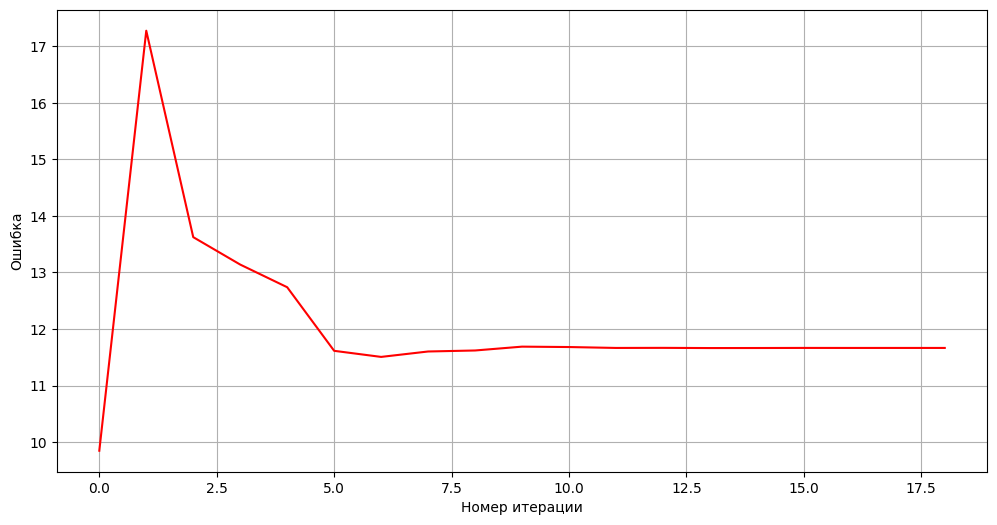

In [78]:
fig, ax = plt.subplots(figsize = (12,6))
plt.plot(error, c = 'red', label = 'Ошибка')
plt.grid()
plt.xlabel('Номер итерации')
plt.ylabel('Ошибка')